# Setup Logging & Imports

In [1]:
DEBUG = True

### Setting up logging

In [2]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("pipeline")

# Show info messages if DEBUG mode is enabled
if DEBUG:
    logger.setLevel(logging.DEBUG)
    logger.debug("DEBUG mode is enabled. Detailed logs will be shown.")
else:
    logger.setLevel(logging.INFO)
    logger.info("DEBUG mode is disabled. Only essential logs will be shown.")

DEBUG:pipeline:DEBUG mode is enabled. Detailed logs will be shown.


### Imports

In [3]:
import os
import torch

# We set up CUDA first to ensure it is configured correctly
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
if torch.cuda.is_available():
    CUDA_DEVICE = torch.device("cuda:0")
    logger.info(f"CUDA is available. Using device: {CUDA_DEVICE}")
else:
    logger.error("CUDA is not available. Please check your PyTorch installation. Using CPU instead...this will be slow.")
    CUDA_DEVICE = torch.device("cpu")

INFO:pipeline:CUDA is available. Using device: cuda:0


In [4]:
from pipeline.proj import load_projection_mat, reformat_sinogram, interpolate_projections, pad_and_reshape, divide_sinogram
from pipeline.aggregate_prj import aggregate_saved_projections
from pipeline.aggregate_ct import aggregate_saved_recons
from pipeline.apply_model import apply_model_to_projections, load_model
# from .infer3d import inference_3d
from pipeline.utils import ensure_dir, read_scans_agg_file
from pipeline.paths import Directories, Files
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import yaml
import importlib
import copy
from tqdm import tqdm
import gc
import tigre.utilities.gpu as gpu
from pipeline.FDK_half.FDK_half import FDKHalf
from pipeline.utils import get_geometry

# TODO run FDK via: FFrecon_reconFDK(input_mat, output_mat); in file "FFrecon_fullFDK.m"

# Configuration

In [5]:
# Scans to convert to PyTorch tensors
# Put None if you don't have any scans to convert
# See the README for how to write this file correctly
# NOTE: This will throw an error if the scan has already been converted
#       If you would like to re-convert a scan,
#       you can delete the file manually
# SCANS_CONVERT = 'scans_convert_to_pt.txt'
SCANS_CONVERT = None

# Phase of the project (all data, models, etc. will be saved under this phase)
PHASE = "7"

# If this data version already exists in this phase, it will be loaded
# Otherwise it will be created using whatever the most updated data creation script is
DATA_VERSION = '13'

# Scans to use for training, val, and testing
# You should set this even if you are not doing aggregation
# See the README for how to write this file correctly
# NOTE: This will NOT throw an error if there are already aggregated scans
#       it will just give a warning and skip the aggregation step
SCANS_AGG = 'scans_to_agg.txt'
# SCANS_AGG = None

# Whether to augment the data for the image domain
# This will only be used if you are doing image domain aggregation
AUGMENT_ID = True

# List of yaml files that contain configurations for the pipeline
# Each file should contain the paramters for a specific model/ensemble
CONFIG_FILES = [
    # "config_01epoch.yaml",
    "config_20epoch.yaml",
]

# Base directory
WORK_ROOT = "D:/NoahSilverberg/ngCBCT"

# NSG_CBCT Path where the raw matlab data is stored
NSG_CBCT_PATH = "D:/MitchellYu/NSG_CBCT"

# Directory with all files specific to this phase/data version
PHASE_DATAVER_DIR = os.path.join(
    WORK_ROOT, f"phase{PHASE}", f"DS{DATA_VERSION}"
)

DIRECTORIES = Directories(
    mat_projections_dir=os.path.join(NSG_CBCT_PATH, "data/prj/HF/mat"),
    pt_projections_dir=os.path.join(WORK_ROOT, "prj_pt"),
    projections_aggregate_dir=os.path.join(PHASE_DATAVER_DIR, "aggregates", "projections"),
    projections_model_dir=os.path.join(PHASE_DATAVER_DIR, "models", "projections"),
    projections_results_dir=os.path.join(PHASE_DATAVER_DIR, "results", "projections"),
    projections_gated_dir=os.path.join(WORK_ROOT, "gated", "prj_mat"),
    reconstructions_dir=os.path.join(PHASE_DATAVER_DIR, "reconstructions"),
    reconstructions_gated_dir=os.path.join(WORK_ROOT, "gated", "fdk_recon"),
    images_aggregate_dir=os.path.join(PHASE_DATAVER_DIR, "aggregates", "images"),
    images_model_dir=os.path.join(PHASE_DATAVER_DIR, "models", "images"),
    images_results_dir=os.path.join(PHASE_DATAVER_DIR, "results", "images"),
)

FILES = Files(DIRECTORIES)

# Data Preparation: projection interpolation

In [6]:
if SCANS_CONVERT is not None:
    # Read the scans to convert file
    with open(SCANS_CONVERT, "r") as f:
        SCANS_CONVERT = []
        for line in f:
            line = line.strip()
            if not line:
                continue
            patient, scan, scan_type = line.split()
            SCANS_CONVERT.append((patient, scan, scan_type))

    logger.debug(f"Loaded scan list for conversion: {SCANS_CONVERT}")

    logger.info("Starting to process projection data...")

    for patient, scan, scan_type in SCANS_CONVERT:
        g_path = FILES.get_projection_pt_filepath(patient, scan, scan_type, gated=True)
        ng_path = FILES.get_projection_pt_filepath(patient, scan, scan_type, gated=False)

        # Make sure the files do not already exist
        if os.path.exists(g_path) or os.path.exists(ng_path):
            logger.warning(f"Projection files already exist for patient {patient}, scan {scan}, type {scan_type}. Skipping...")
            continue

        # Load the projection data from the matlab files
        mat_path = FILES.get_projection_mat_filepath(patient, scan, scan_type)
        odd_index, angles, prj = load_projection_mat(mat_path)

        # Log shapes of loaded data
        logger.debug(f'Processing patient {patient}, scan {scan}, type {scan_type}')
        logger.debug(f'Loaded odd_index shape: {odd_index.shape}')
        logger.debug(f'Loaded angles shape: {angles.shape}')
        logger.debug(f'Loaded projection shape: {prj.shape}')

        # Flip and permute to get it in the right format
        prj_gcbct, angles1 = reformat_sinogram(prj, angles)

        # Log shapes after reformatting
        logger.debug(f'Reformatted projection shape: {prj_gcbct.shape}')

        # Simulate ngCBCT projections
        prj_ngcbct_li = interpolate_projections(prj_gcbct, odd_index)

        # Log shapes after interpolation
        logger.debug(f'Interpolated ngCBCT projection shape: {prj_ngcbct_li.shape}')

        # Split the projections into two halves so they are good dimensions for the CNN
        combined_gcbct = divide_sinogram(pad_and_reshape(prj_gcbct), v_dim=512 if scan_type == "HF" else 256)
        combined_ngcbct = divide_sinogram(pad_and_reshape(prj_ngcbct_li), v_dim=512 if scan_type == "HF" else 256)

        # Log shapes after dividing sinograms
        logger.debug(f'Combined gCBCT shape: {combined_gcbct.shape}')
        logger.debug(f'Combined ngCBCT shape: {combined_ngcbct.shape}')

        logger.debug(f'Saving projections...')
        
        # Save the projections
        torch.save(combined_gcbct, g_path)
        torch.save(combined_ngcbct, ng_path)

        logger.debug(f'Done with patient {patient}, scan {scan}, type {scan_type}\n')

    logger.info("All projections saved successfully.")

    # Free up memory
    del odd_index, angles, prj, prj_gcbct, angles1, prj_ngcbct_li, combined_gcbct, combined_ngcbct
else:
    logger.info("No scans to convert. Skipping projection data processing.")

INFO:pipeline:No scans to convert. Skipping projection data processing.


### DEBUG: Sample projections

In [7]:
if DEBUG and SCANS_CONVERT is not None:
    # Pick the first HF scan and first FF scan
    hf_scan = None
    ff_scan = None
    for patient, scan, scan_type in SCANS_CONVERT:
        if scan_type == "HF":
            hf_scan = (patient, scan, scan_type)
            break
    for patient, scan, scan_type in SCANS_CONVERT:
        if scan_type == "FF":
            ff_scan = (patient, scan, scan_type)
            break

    # Display the first HF scan
    # Show the gated and nonstop-gated on subplots
    if hf_scan:
        hf_patient, hf_scan_num, hf_scan_type = hf_scan
        g_path = FILES.get_projection_pt_filepath(hf_patient, hf_scan_num, hf_scan_type, gated=True)
        ng_path = FILES.get_projection_pt_filepath(hf_patient, hf_scan_num, hf_scan_type, gated=False)
        hf_gated_prj = torch.load(g_path)
        hf_ng_prj = torch.load(ng_path)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(hf_gated_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
        plt.title(f'Gated Projection - {hf_scan_type} p{hf_patient}_{hf_scan_num}')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(hf_ng_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
        plt.title(f'Nonstop-Gated Projection - {hf_scan_type} p{hf_patient}_{hf_scan_num}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Free up memory
        del hf_gated_prj, hf_ng_prj

    # Repeat for FF scan
    if ff_scan:
        ff_patient, ff_scan_num, ff_scan_type = ff_scan
        g_path = FILES.get_projection_pt_filepath(ff_patient, ff_scan_num, ff_scan_type, gated=True)
        ff_gated_prj = torch.load(g_path)
        ng_path = FILES.get_projection_pt_filepath(ff_patient, ff_scan_num, ff_scan_type, gated=False)
        ff_ng_prj = torch.load(ng_path)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(ff_gated_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
        plt.title(f'Gated Projection - {ff_scan_type} p{ff_patient}_{ff_scan_num}')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(ff_ng_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
        plt.title(f'Nonstop-Gated Projection - {ff_scan_type} p{ff_patient}_{ff_scan_num}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Free up memory
        del ff_gated_prj, ff_ng_prj

# Aggregate projections for train/val/test

In [8]:
if SCANS_AGG is not None:
    scans_agg, scan_type = read_scans_agg_file(SCANS_AGG)
    logger.debug(f"Loaded scan list for aggregation: {scans_agg}")

    # Only aggregate projections if they don't already exist
    agg_dir = DIRECTORIES.projections_aggregate_dir
    if agg_dir is None:
        logger.warning("No aggregation directory specified. Skipping projection data aggregation.")
    elif len(os.listdir(agg_dir)) > 0:
        logger.warning(f"Aggregated projection data already exists in {agg_dir}. Skipping...")
    else:
        logger.info("Starting to aggregate projection data...")
        
        # Aggregate and save projection data sets
        for split in ['TRAIN', 'VALIDATION', 'TEST']:
            if len(scans_agg[split]) > 0:
                ng_paths = [FILES.get_projection_pt_filepath(patient, scan, scan_type, gated=False) for patient, scan, scan_type in scans_agg[split]]
                prj_ngcbct = aggregate_saved_projections(ng_paths)
                ng_agg_path = FILES.get_projections_aggregate_filepath(split, gated=False)
                np.save(ng_agg_path, prj_ngcbct.numpy())
                del prj_ngcbct
                logger.debug("Done with nonstop-gated...")
                g_paths = [FILES.get_projection_pt_filepath(patient, scan, scan_type, gated=True) for patient, scan, scan_type in scans_agg[split]]
                prj_gcbct = aggregate_saved_projections(g_paths)
                g_agg_path = FILES.get_projections_aggregate_filepath(split, gated=True)
                np.save(g_agg_path, prj_gcbct.numpy())
                del prj_gcbct
                logger.debug("Done with gated...")

                logger.debug(f"Aggregated projections saved for {scan_type} {split}.\n")
            else:
                logger.debug(f"No scans to aggregate for {scan_type} {split}. Skipping aggregation.")

        # Free up memory
        del prj_gcbct, prj_ngcbct

        logger.info("Projection data aggregation completed successfully.")
        logger.info("Aggregated projection data saved in: %s", agg_dir)
else:
    logger.info("No scans to aggregate. Skipping projection data aggregation.")

DEBUG:pipeline:Loaded scan list for aggregation: {'TRAIN': [('01', '01', 'HF'), ('01', '02', 'HF'), ('01', '03', 'HF'), ('01', '04', 'HF'), ('01', '05', 'HF'), ('01', '06', 'HF'), ('03', '01', 'HF'), ('04', '01', 'HF'), ('04', '02', 'HF'), ('04', '03', 'HF'), ('05', '01', 'HF'), ('06', '01', 'HF'), ('06', '02', 'HF'), ('09', '01', 'HF'), ('11', '01', 'HF'), ('11', '02', 'HF'), ('11', '03', 'HF'), ('11', '04', 'HF'), ('11', '05', 'HF'), ('12', '01', 'HF'), ('12', '02', 'HF'), ('12', '03', 'HF'), ('12', '04', 'HF'), ('13', '01', 'HF'), ('13', '02', 'HF'), ('13', '03', 'HF'), ('13', '04', 'HF'), ('13', '05', 'HF'), ('13', '06', 'HF'), ('17', '01', 'HF'), ('18', '01', 'HF'), ('18', '02', 'HF'), ('18', '03', 'HF'), ('18', '04', 'HF'), ('19', '01', 'HF'), ('19', '02', 'HF'), ('21', '01', 'HF'), ('21', '02', 'HF'), ('21', '03', 'HF'), ('21', '04', 'HF'), ('23', '01', 'HF'), ('23', '02', 'HF')], 'VALIDATION': [('02', '01', 'HF'), ('02', '02', 'HF'), ('16', '01', 'HF'), ('16', '02', 'HF'), ('22

# Training PD CNN

In [9]:
for config_file in CONFIG_FILES:
    # Load the yaml configuration file
    with open(config_file, "r") as f:
        config = yaml.safe_load(f)
    
    logger.debug(f"Loaded configuration from {config_file}")

    # Skip this config if the user has set PD_training to False
    if not config['PD_settings']['training']:
        logger.info(f"Skipping PD training for {config_file} as PD training is set to False.")
        continue

    # Get the training application
    module_name, class_name = config['PD_settings']['training_app'].rsplit('.', 1)
    module = importlib.import_module("pipeline." + module_name)
    cls = getattr(module, class_name)

    logger.debug(f"Loaded class {class_name} from module {module_name}")

    # Get the model version (for naming purposes)
    model_version = config['PD_settings']['model_version']

    # Get the ensemble size, and loop through it
    ensemble_size = config['PD_settings']['ensemble_size']
    for i in range(ensemble_size):
        # If we are training an ensemble, we add an identifier to the model version
        if ensemble_size > 1:
            # Deepcopy config so we don't affect the original
            cfg = copy.deepcopy(config)
            cfg['PD_settings']['model_version'] = f"{model_version}_{i+1:02}" # e.g., "v1_01"
        else:
            cfg = config

        # Add the data version to the configuration
        cfg['PD_settings']['data_version'] = DATA_VERSION

        # Instantiate with the loaded configuration
        instance = cls(cfg, "PROJ", DEBUG, FILES)

        logger.info(f"Going to try training the {i + 1}-th model with configuration from {config_file}...")

        # Run the training
        instance.main()

        logger.info(f"Finished training the {i + 1}-th model.\n")

        del instance, cfg
        gc.collect()

    # Free up memory
    del module, cls, config, module_name, class_name

DEBUG:pipeline:Loaded configuration from config_20epoch.yaml
INFO:pipeline:Skipping PD training for config_20epoch.yaml as PD training is set to False.


# TEMP

In [10]:
gpuids = gpu.getGpuIds()
gpuids.devices = [0]
geo = get_geometry()

if SCANS_AGG is None:
    logger.info("Skipping model application as the aggregation scan list is not provided.")
else:
    # Loop through the configurations again
    for config_file in CONFIG_FILES:
        # Load the yaml configuration file
        with open(config_file, "r") as f:
            config = yaml.safe_load(f)

        logger.debug(f"Loaded configuration from {config_file}")

        # Get the ensemble size, and loop through it
        ensemble_size = config['PD_settings']['ensemble_size']
        for i in range(ensemble_size):
            model_version = config['PD_settings']['model_version']

            # If we are training an ensemble, we add an identifier to the model version
            if ensemble_size > 1:
                model_version = f"{model_version}_{i+1:02}"

            scan_type_model = config['PD_settings']['scan_type']

            # Load the trained PD model onto the GPU
            model_path = FILES.get_model_filepath(model_version, "PROJ")
            PD_model = load_model(config['PD_settings']['network_name'], model_path, CUDA_DEVICE)

            scans_agg, scan_type = read_scans_agg_file(SCANS_AGG)
            if scan_type != config['PD_settings']['scan_type']:
                raise ValueError(f"Scan type in aggregation file ({scan_type}) does not match scan type in config ({config['PD_settings']['scan_type']}).")
            
            for split in ['TRAIN', 'VALIDATION', 'TEST']:
                for patient, scan, scan_type in tqdm(scans_agg[split], desc=f"Applying model {model_version} to projections split {split}"):
                    # Get the matlab dicts for the ground truth and CNN projections
                    mat_path = FILES.get_projection_mat_filepath(patient, scan, scan_type)
                    gated_pt_path = FILES.get_projection_pt_filepath(patient, scan, scan_type, gated=True)
                    ng_pt_path = FILES.get_projection_pt_filepath(patient, scan, scan_type, gated=False)
                    
                    # Save the ground truth and CNN projections
                    gated_path = FILES.get_projections_results_filepath(model_version, patient, scan, scan_type, gated=True)
                    ng_path = FILES.get_projections_results_filepath(model_version, patient, scan, scan_type, gated=False)
                    g_recon_path = FILES.get_recon_filepath(model_version, patient, scan, scan_type, gated=True)
                    ng_recon_path = FILES.get_recon_filepath(model_version, patient, scan, scan_type, gated=False)

                    if split != "TEST" and os.path.exists(ng_recon_path):
                        logger.info(f"Projections and reconstructions results already exist for {scan_type} p{patient}_{scan} for model {model_version}. Skipping...")
                        continue

                    if split == "TEST" and os.path.exists(ng_path) and os.path.exists(ng_recon_path):
                        logger.info(f"Nonstop-gated projections and reconstructions already exist for {scan_type} p{patient}_{scan} for model {model_version}. Skipping...")
                        continue

                    g_mat, cnn_mat = apply_model_to_projections(PD_model, scan_type, mat_path, gated_pt_path, ng_pt_path, CUDA_DEVICE)

                    if split == "TEST" and not os.path.exists(ng_path):
                        scipy.io.savemat(ng_path, cnn_mat)
                        logger.debug(f"Saved CNN projections for {scan_type} p{patient}_{scan} to {ng_path}.")

                    if not os.path.exists(g_recon_path):    
                        g_fdk_half = FDKHalf()(g_mat['prj'], get_geometry(), g_mat['angles'].flatten(), filter='hann', parker=True)
                        g_fdk_half = torch.from_numpy(g_fdk_half).detach()
                        
                        # Save the recon results as .pt
                        torch.save(g_fdk_half, g_recon_path)
                        logger.debug(f"Saved gated reconstruction for {scan_type} p{patient}_{scan} to {g_recon_path}.")
                    else:
                        logger.debug(f"Gated reconstruction already exists for {scan_type} p{patient}_{scan}.")

                    if not os.path.exists(ng_recon_path):
                        ng_fdk_half = FDKHalf()(cnn_mat['prj'], get_geometry(), cnn_mat['angles'].flatten(), filter='hann', parker=True)
                        ng_fdk_half = torch.from_numpy(ng_fdk_half).detach()
                        
                        # Save the recon results as .pt
                        torch.save(ng_fdk_half, ng_recon_path)
                        logger.debug(f"Saved nonstop-gated reconstruction for {scan_type} p{patient}_{scan} to {ng_recon_path}.")
                    else:
                        logger.debug(f"Nonstop-gated reconstruction already exists for {scan_type} p{patient}_{scan}.")

                    logger.debug(f"Saved projections for {scan_type} p{patient}_{scan}.")

                    del g_mat, cnn_mat, ng_fdk_half
                    try:
                        del g_fdk_half
                    except:
                        pass

            # Free up memory
            del PD_model

    logger.info("All models applied to projections.")

DEBUG:pipeline:Loaded configuration from config_20epoch.yaml


Applying model MK7_01 to projections split TRAIN:   0%|          | 0/42 [00:00<?, ?it/s]INFO:pipeline:Projections and reconstructions results already exist for HF p01_01 for model MK7_01. Skipping...
INFO:pipeline:Projections and reconstructions results already exist for HF p01_02 for model MK7_01. Skipping...
INFO:pipeline:Projections and reconstructions results already exist for HF p01_03 for model MK7_01. Skipping...
INFO:pipeline:Projections and reconstructions results already exist for HF p01_04 for model MK7_01. Skipping...
INFO:pipeline:Projections and reconstructions results already exist for HF p01_05 for model MK7_01. Skipping...
INFO:pipeline:Projections and reconstructions results already exist for HF p01_06 for model MK7_01. Skipping...
INFO:pipeline:Projections and reconstructions results already exist for HF p03_01 for model MK7_01. Skipping...
INFO:pipeline:Projections and reconstructions results already exist for HF p04_01 for model MK7_01. Skipping...
INFO:pipeline:Pr

# Apply PD model to all nonstop-gated sinograms

In [11]:
# if SCANS_AGG is None:
#     logger.info("Skipping model application as the aggregation scan list is not provided.")
# else:
#     # Loop through the configurations again
#     for config_file in CONFIG_FILES:
#         # Load the yaml configuration file
#         with open(config_file, "r") as f:
#             config = yaml.safe_load(f)

#         logger.debug(f"Loaded configuration from {config_file}")

#         # Get the ensemble size, and loop through it
#         ensemble_size = config['PD_settings']['ensemble_size']
#         for i in range(ensemble_size):
#             model_version = config['PD_settings']['model_version']

#             # If we are training an ensemble, we add an identifier to the model version
#             if ensemble_size > 1:
#                 model_version = f"{model_version}_{i+1:02}"

#             scan_type_model = config['PD_settings']['scan_type']

#             # Load the trained PD model onto the GPU
#             model_path = FILES.get_model_filepath(model_version, "PROJ")
#             PD_model = load_model(config['PD_settings']['network_name'], model_path, CUDA_DEVICE)

#             scans_agg, scan_type = read_scans_agg_file(SCANS_AGG, list_=True)
#             if scan_type != config['PD_settings']['scan_type']:
#                 raise ValueError(f"Scan type in aggregation file ({scan_type}) does not match scan type in config ({config['PD_settings']['scan_type']}).")
            
#             for patient, scan, scan_type in tqdm(scans_agg, desc=f"Applying model {model_version} to projections"):
#                 # Get the matlab dicts for the ground truth and CNN projections
#                 mat_path = FILES.get_projection_mat_filepath(patient, scan, scan_type)
#                 gated_pt_path = FILES.get_projection_pt_filepath(patient, scan, scan_type, gated=True)
#                 ng_pt_path = FILES.get_projection_pt_filepath(patient, scan, scan_type, gated=False)
                
#                 # Save the ground truth and CNN projections
#                 gated_path = FILES.get_projections_results_filepath(model_version, patient, scan, scan_type, gated=True)
#                 ng_path = FILES.get_projections_results_filepath(model_version, patient, scan, scan_type, gated=False)

#                 if os.path.exists(ng_path):
#                     logger.info(f"Projections results already exist for {scan_type} p{patient}_{scan} for model {model_version}. Skipping...")
#                     continue

#                 g_mat, cnn_mat = apply_model_to_projections(PD_model, scan_type, mat_path, gated_pt_path, ng_pt_path, CUDA_DEVICE)

#                 if os.path.exists(gated_path):
#                     logger.info(f"Ground-truth projections already exist for {scan_type} p{patient}_{scan}. Skipping...")
#                 else:
#                     scipy.io.savemat(gated_path, g_mat)
#                 scipy.io.savemat(ng_path, cnn_mat)

#                 logger.debug(f"Saved projections for {scan_type} p{patient}_{scan}.")

#                 del g_mat, cnn_mat

#             # Free up memory
#             del PD_model

#     logger.info("All models applied to projections.")

# Apply FDK to all projections that were processed by the PD model

In [12]:
# # TODO do we do this differently for FF?
# gpuids = gpu.getGpuIds()
# gpuids.devices = [0]
# geo = get_geometry()

# # Loop through the configurations again
# for config_file in CONFIG_FILES:
#     # Load the yaml configuration file
#     with open(config_file, "r") as f:
#         config = yaml.safe_load(f)

#     logger.debug(f"Loaded configuration from {config_file}")

#     # Get the ensemble size, and loop through it
#     ensemble_size = config['PD_settings']['ensemble_size']
#     for i in range(ensemble_size):
#         model_version = config['PD_settings']['model_version']

#         # If we are training an ensemble, we add an identifier to the model version
#         if ensemble_size > 1:
#             model_version = f"{model_version}_{i+1:02}"

#         scan_type_model = config['PD_settings']['scan_type']

#         # Load the trained PD model onto the GPU
#         model_path = FILES.get_model_filepath(model_version, "PROJ")
#         PD_model = load_model(config['PD_settings']['network_name'], model_path, torch.device(CUDA_DEVICE))
            
#         scans_agg, scan_type = read_scans_agg_file(SCANS_AGG, list_=True)
#         if scan_type != config['PD_settings']['scan_type']:
#             raise ValueError(f"Scan type in aggregation file ({scan_type}) does not match scan type in config ({config['PD_settings']['scan_type']}).")

#         for patient, scan, scan_type in tqdm(scans_agg, desc=f"Applying FDK to gated and nonstop-gated projections for model {model_version}"):
#             for gated in [True, False]:
#                 # Load the scan and perform FDK reconstruction
#                 result_path = FILES.get_projections_results_filepath(model_version, patient, scan, scan_type, gated=gated)
                
#                 recon_path = FILES.get_recon_filepath(model_version, patient, scan, scan_type, gated=gated)
#                 if os.path.exists(recon_path):
#                     logger.info(f"{'Gated' if gated else 'Nonstop-gated'} reconstruction already exists for {scan_type} p{patient}_{scan}. Skipping...")
#                     continue

#                 mat = scipy.io.loadmat(result_path)
#                 fdk_half = FDKHalf()(mat['prj'], get_geometry(), mat['angles'].flatten(), filter='hann', parker=True)
#                 fdk_half = torch.from_numpy(fdk_half).detach()

#                 # Save the recon results as .pt
#                 torch.save(fdk_half, recon_path)

#                 logger.debug(f"Saved {'gated' if gated else 'nonstop-gated'} projection for {scan_type} p{patient}_{scan}.")

#                 # Delete the nonstop-gated result to free storage space
#                 if not gated:
#                     os.remove(result_path)
#                     logger.debug(f"Deleted nonstop-gated projection file {result_path} to save storage space.")

#                 del fdk_half, mat

#         # Free up memory
#         del PD_model

# logger.info("All models applied to projections.")

# Aggregate CT volumes for train/val/test

DEBUG:pipeline:Loaded scan list for aggregation: {'TRAIN': [('01', '01', 'HF'), ('01', '02', 'HF'), ('01', '03', 'HF'), ('01', '04', 'HF'), ('01', '05', 'HF'), ('01', '06', 'HF'), ('03', '01', 'HF'), ('04', '01', 'HF'), ('04', '02', 'HF'), ('04', '03', 'HF'), ('05', '01', 'HF'), ('06', '01', 'HF'), ('06', '02', 'HF'), ('09', '01', 'HF'), ('11', '01', 'HF'), ('11', '02', 'HF'), ('11', '03', 'HF'), ('11', '04', 'HF'), ('11', '05', 'HF'), ('12', '01', 'HF'), ('12', '02', 'HF'), ('12', '03', 'HF'), ('12', '04', 'HF'), ('13', '01', 'HF'), ('13', '02', 'HF'), ('13', '03', 'HF'), ('13', '04', 'HF'), ('13', '05', 'HF'), ('13', '06', 'HF'), ('17', '01', 'HF'), ('18', '01', 'HF'), ('18', '02', 'HF'), ('18', '03', 'HF'), ('18', '04', 'HF'), ('19', '01', 'HF'), ('19', '02', 'HF'), ('21', '01', 'HF'), ('21', '02', 'HF'), ('21', '03', 'HF'), ('21', '04', 'HF'), ('23', '01', 'HF'), ('23', '02', 'HF')], 'VALIDATION': [('02', '01', 'HF'), ('02', '02', 'HF'), ('16', '01', 'HF'), ('16', '02', 'HF'), ('22

torch.Size([200, 512, 512])
torch.Size([160, 512, 512])


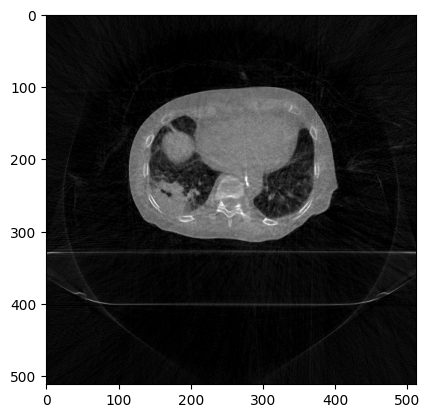

Aggregating reconstructions: 0it [00:00, ?it/s]


RuntimeError: No active exception to reraise

In [ ]:
if SCANS_AGG is not None:
    scans_agg, scan_type = read_scans_agg_file(SCANS_AGG)
    logger.debug(f"Loaded scan list for aggregation: {scans_agg}")

    # Load the yaml configuration file
    with open(config_file, "r") as f:
        config = yaml.safe_load(f)
    
    logger.debug(f"Loaded configuration from {config_file}")

    input_type = config['ID_settings']['input_type']

    # Get the ensemble size, and loop through it
    ensemble_size = config['ID_settings']['ensemble_size']
    for i in range(ensemble_size):
        # If we are training an ensemble, we add an identifier to the model version
        if ensemble_size > 1 and config['ID_settings']['input_type_match_ensemble']:
            input_type = f"{input_type}_{i+1:02}" # e.g., "v1_01"

        # Only aggregate reconstructions if they don't already exist
        agg_dir = DIRECTORIES.get_images_aggregate_dir(input_type)
        if len(os.listdir(agg_dir)) > 0:
            logger.warning(f"Aggregated reconstruction data already exists in {agg_dir}. Skipping...")
        else:
            logger.info("Starting to aggregate reconstruction data...")

            # Aggregate and save reconstruction data sets
            for split in ['TRAIN', 'VALIDATION', 'TEST']:
                if len(scans_agg[split]) > 0:
                    ng_paths = [FILES.get_recon_filepath(input_type, patient, scan, scan_type, gated=False) for patient, scan, scan_type in scans_agg[split]]
                    recon_ngcbct = aggregate_saved_recons(ng_paths, augment=AUGMENT_ID)
                    ng_agg_path = FILES.get_images_aggregate_filepath(input_type, split, gated=False)
                    np.save(ng_agg_path, recon_ngcbct.numpy())
                    del recon_ngcbct
                    logger.debug("Done with nonstop-gated...")
                    g_paths = [FILES.get_recon_filepath(input_type, patient, scan, scan_type, gated=True) for patient, scan, scan_type in scans_agg[split]]
                    recon_gcbct = aggregate_saved_recons(g_paths, augment=AUGMENT_ID)
                    g_agg_path = FILES.get_images_aggregate_filepath('fdk', split, gated=True)
                    np.save(g_agg_path, recon_gcbct.numpy())
                    del recon_gcbct
                    logger.debug("Done with gated...")

                    logger.debug(f"Aggregated reconstructions saved for {scan_type} {split}.\n")
                else:
                    logger.debug(f"No scans to aggregate for {scan_type} {split}. Skipping aggregation.")

            # Free up memory
            del recon_gcbct, recon_ngcbct

        logger.info("Reconstruction data aggregation completed successfully.")
        logger.info("Aggregated reconstruction data saved in: %s", agg_dir)
else:
    logger.info("No scans to aggregate. Skipping reconstruction data aggregation.")

# Train ID CNN

In [ ]:
for config_file in CONFIG_FILES:
    # Load the yaml configuration file
    with open(config_file, "r") as f:
        config = yaml.safe_load(f)
    
    logger.debug(f"Loaded configuration from {config_file}")

    # Skip this config if the user has set ID_training to False
    if not config['ID_settings']['training']:
        logger.info(f"Skipping ID training for {config_file} as ID training is set to False.")
        continue

    # Get the training application
    module_name, class_name = config['ID_settings']['training_app'].rsplit('.', 1)
    module = importlib.import_module("pipeline." + module_name)
    cls = getattr(module, class_name)

    logger.debug(f"Loaded class {class_name} from module {module_name}")

    # Get the model version (for naming purposes)
    model_version = config['ID_settings']['model_version']

    # Get the ensemble size, and loop through it
    ensemble_size = config['ID_settings']['ensemble_size']
    for i in range(ensemble_size):
        # If we are training an ensemble, we add an identifier to the model version
        if ensemble_size > 1:
            # Deepcopy config so we don't affect the original
            cfg = copy.deepcopy(config)
            cfg['ID_settings']['model_version'] = f"{model_version}_{i+1:02}" # e.g., "v1_01"
            if config['ID_settings']['input_type_match_ensemble']:
                cfg['ID_settings']['input_type'] = f"{cfg['ID_settings']['input_type']}_{i+1:02}"
        else:
            cfg = config

        # Add the data version to the configuration
        cfg['ID_settings']['data_version'] = DATA_VERSION

        # Instantiate with the loaded configuration
        instance = cls(cfg, "IMAG", DEBUG, MODEL_DIR, AGG_DIR)

        logger.info(f"Going to try training the {i + 1}-th model with configuration from {config_file}...")

        # Run the training
        instance.main()

        logger.info(f"Finished training the {i + 1}-th model.\n")

        del instance, cfg
        gc.collect()

    # Free up memory
    del module, cls, config, module_name, class_name

# Pass all samples through the ID model